In [1]:
#set up environment
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from sklearn import model_selection
from sklearn.metrics import classification_report
import matplotlib.pyplot as pyplot
from sklearn.calibration import calibration_curve
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score , log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.impute import SimpleImputer
import time
from sklearn.svm import SVC

#load data and visualize
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [5]:
df['last_trip_date'].describe()

count          50000
unique           182
top       2014-06-29
freq            2036
Name: last_trip_date, dtype: object

Fraction retained is only 37% as of Jun 2014

In [6]:
fraction_retained = (df.last_trip_date >= '2014-06-01').sum() / (df.last_trip_date >= '2014-06-01').count()
fraction_retained

0.37608

In [7]:
#encode target variable 'active' as true or false for last trip in june
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['active'] = [1 if x.month >= 6 else 0 for x in df.last_trip_date]
#encode ultimate_black_user as categorical 
df['ultimate_black_user'] = [1 if x == True else 0 for x in df.ultimate_black_user]

df.describe()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
count,50000.000000,50000,41878.000000,50000.000000,50000,50000.000000,50000.00000,50000.000000,50000.000000,49799.000000,50000.000000
mean,2.278200,2014-01-16 13:04:20.352000,4.601559,1.074764,2014-04-19 08:02:04.992000256,8.849536,0.37708,60.926084,5.796827,4.778158,0.376080
min,0.000000,2014-01-01 00:00:00,1.000000,1.000000,2014-01-01 00:00:00,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,2014-01-09 00:00:00,4.300000,1.000000,2014-02-14 00:00:00,0.000000,0.00000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,2014-01-17 00:00:00,4.900000,1.000000,2014-05-08 00:00:00,0.000000,0.00000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,2014-01-24 00:00:00,5.000000,1.050000,2014-06-18 00:00:00,8.600000,1.00000,100.000000,6.940000,5.000000,1.000000
max,125.000000,2014-01-31 00:00:00,5.000000,8.000000,2014-07-01 00:00:00,100.000000,1.00000,100.000000,160.960000,5.000000,1.000000
std,3.792684,NaN,0.617338,0.222336,NaN,19.958811,0.48466,37.081503,5.707357,0.446652,0.484405


In [8]:
df['last_trip_date'] = df['last_trip_date'].dt.strftime('%Y%m%d').astype(int) - 20140100
df['signup_date'] = df['signup_date'].dt.strftime('%Y%m%d').astype(int) - 20140100


<Figure size 1200x800 with 0 Axes>

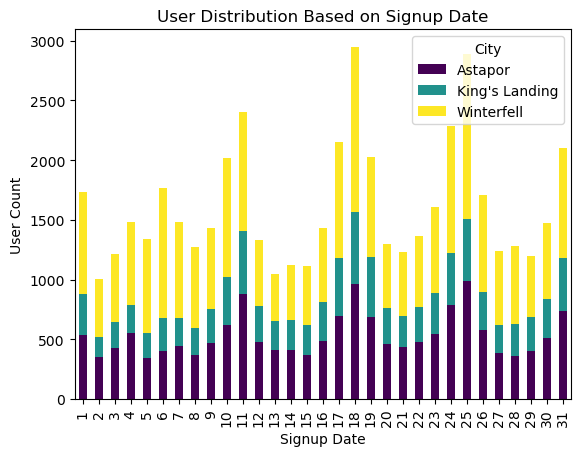

In [9]:
# User distribution in different cities based on cities
user_distribution = df.groupby(['signup_date', 'city']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(12, 8))

# Bar plot
user_distribution.plot(kind='bar', stacked=True, cmap='viridis')

# Set labels and title
plt.xlabel('Signup Date')
plt.ylabel('User Count')
plt.title('User Distribution Based on Signup Date')

# Show legend
plt.legend(title='City', loc='upper right')

# Show plot
plt.show()

<Figure size 1200x800 with 0 Axes>

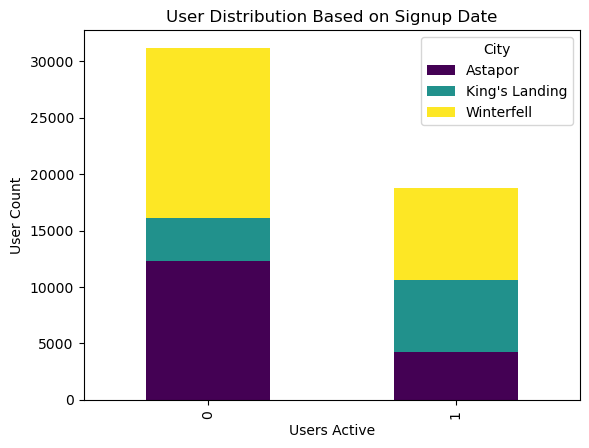

In [10]:
# Which city has retained most signed up users
user_distribution = df.groupby(['active', 'city']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(12, 8))

# Bar plot
user_distribution.plot(kind='bar', stacked=True, cmap='viridis')

# Set labels and title
plt.xlabel('Users Active')
plt.ylabel('User Count')
plt.title('User Distribution Based on Signup Date')

# Show legend
plt.legend(title='City', loc='upper right')

# Show plot
plt.show()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  int32  
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  int32  
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  int64  
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
 12  active                  50000 non-null  int64  
dtypes: float64(6), int32(2), int64(3), object(2)
memory usage: 4.6+ MB


In [12]:
print(df.city.value_counts())
print(df.phone.value_counts())
print(df.isnull().sum())


city
Winterfell        23336
Astapor           16534
King's Landing    10130
Name: count, dtype: int64
phone
iPhone     34582
Android    15022
Name: count, dtype: int64
city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
active                       0
dtype: int64


active                     0     1
phone   city                      
Android Astapor         4599   645
        King's Landing  1406  1092
        Winterfell      5871  1409
iPhone  Astapor         7616  3553
        King's Landing  2335  5233
        Winterfell      9106  6739
other   Astapor           91    30
        King's Landing    26    38
        Winterfell       146    65


<Figure size 1200x800 with 0 Axes>

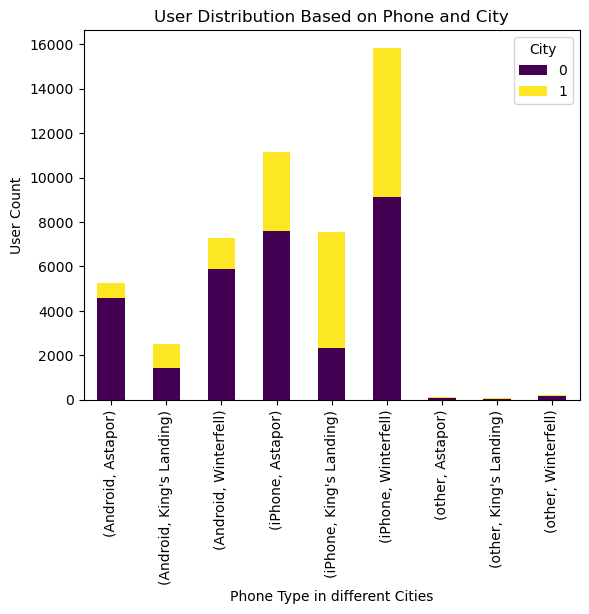

In [13]:
df.phone.fillna('other',inplace = True);
# User distribution based on Phone and City
user_distribution = df.groupby(['phone', 'city','active']).size().unstack(fill_value=0)

print(user_distribution)

# Plot
plt.figure(figsize=(12, 8))

# Bar plot
user_distribution.plot(kind='bar', stacked=True, cmap='viridis')

# Set labels and title
plt.xlabel('Phone Type in different Cities')
plt.ylabel('User Count')
plt.title('User Distribution Based on Phone and City')

# Show legend
plt.legend(title='City', loc='upper right')

# Show plot
plt.show()

In [14]:

df_encoded = pd.get_dummies(df, columns=['city', 'phone'], prefix=['city', 'phone'])


In [15]:
df_encoded.isnull().sum()

trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
active                       0
city_Astapor                 0
city_King's Landing          0
city_Winterfell              0
phone_Android                0
phone_iPhone                 0
phone_other                  0
dtype: int64

In [16]:
df_encoded.rename(columns={"city_King's Landing": 'city_Kings_Landing'}, inplace=True)


In [17]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   signup_date             50000 non-null  int32  
 2   avg_rating_of_driver    41878 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   last_trip_date          50000 non-null  int32  
 5   surge_pct               50000 non-null  float64
 6   ultimate_black_user     50000 non-null  int64  
 7   weekday_pct             50000 non-null  float64
 8   avg_dist                50000 non-null  float64
 9   avg_rating_by_driver    49799 non-null  float64
 10  active                  50000 non-null  int64  
 11  city_Astapor            50000 non-null  bool   
 12  city_Kings_Landing      50000 non-null  bool   
 13  city_Winterfell         50000 non-null  bool   
 14  phone_Android           50000 non-null

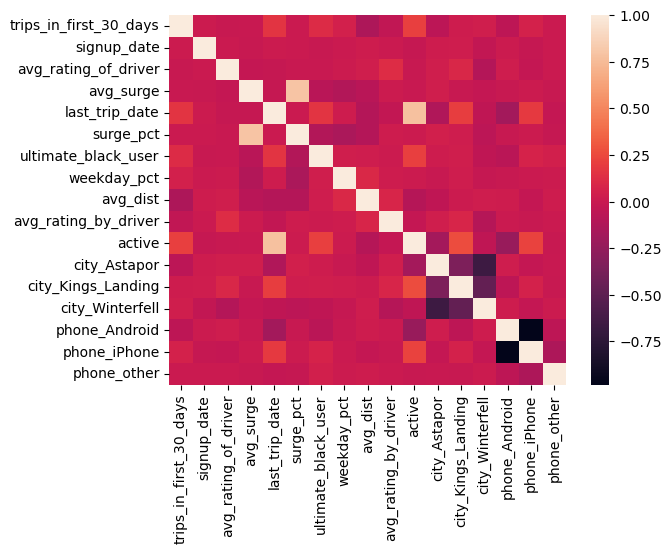

In [18]:
fig = plt.figure()
ax = plt.subplot(111)

corr = df_encoded.corr()
ax = sns.heatmap(corr)
plt.show()

In [19]:
corr['active'].sort_values(ascending=False)

active                    1.000000
last_trip_date            0.776722
city_Kings_Landing        0.262284
phone_iPhone              0.225244
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
phone_other              -0.007419
avg_rating_of_driver     -0.011653
signup_date              -0.020211
avg_rating_by_driver     -0.026791
city_Winterfell          -0.046611
avg_dist                 -0.092780
city_Astapor             -0.174655
phone_Android            -0.225464
Name: active, dtype: float64

In [20]:
print(df_encoded.isnull().sum())

trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
active                       0
city_Astapor                 0
city_Kings_Landing           0
city_Winterfell              0
phone_Android                0
phone_iPhone                 0
phone_other                  0
dtype: int64


In [21]:
df_model = df_encoded.drop(columns =['avg_rating_of_driver','avg_rating_by_driver','avg_surge','phone_other','avg_dist'])

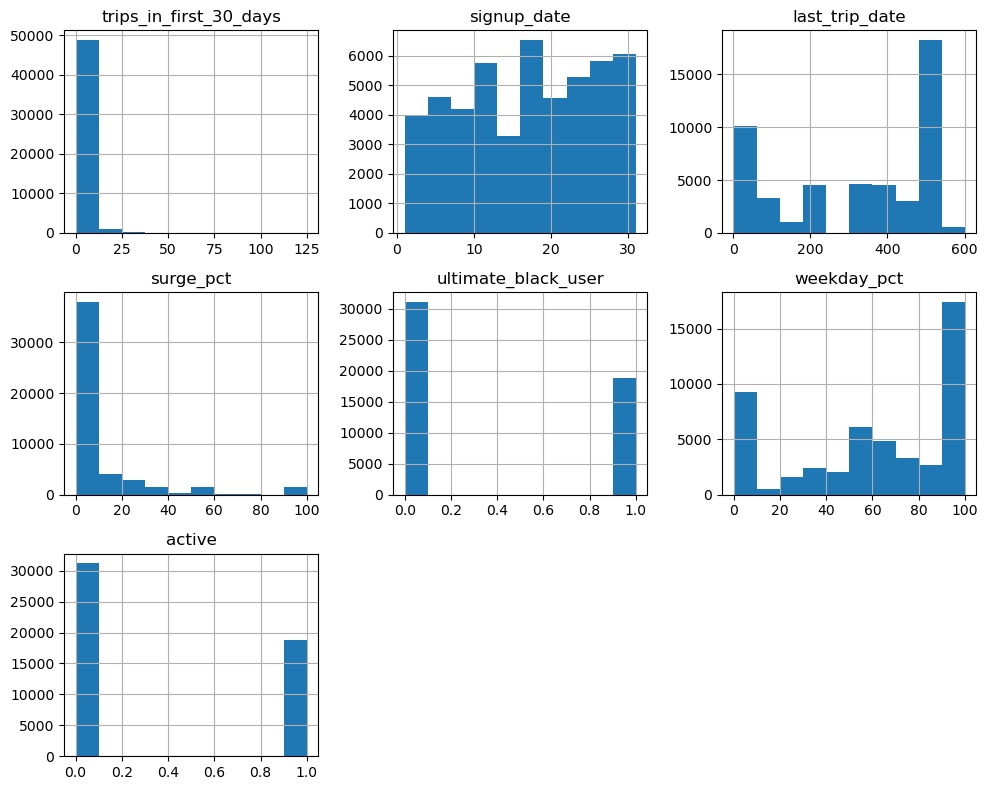

In [22]:
df_model.hist(figsize=(10,8))
plt.tight_layout()

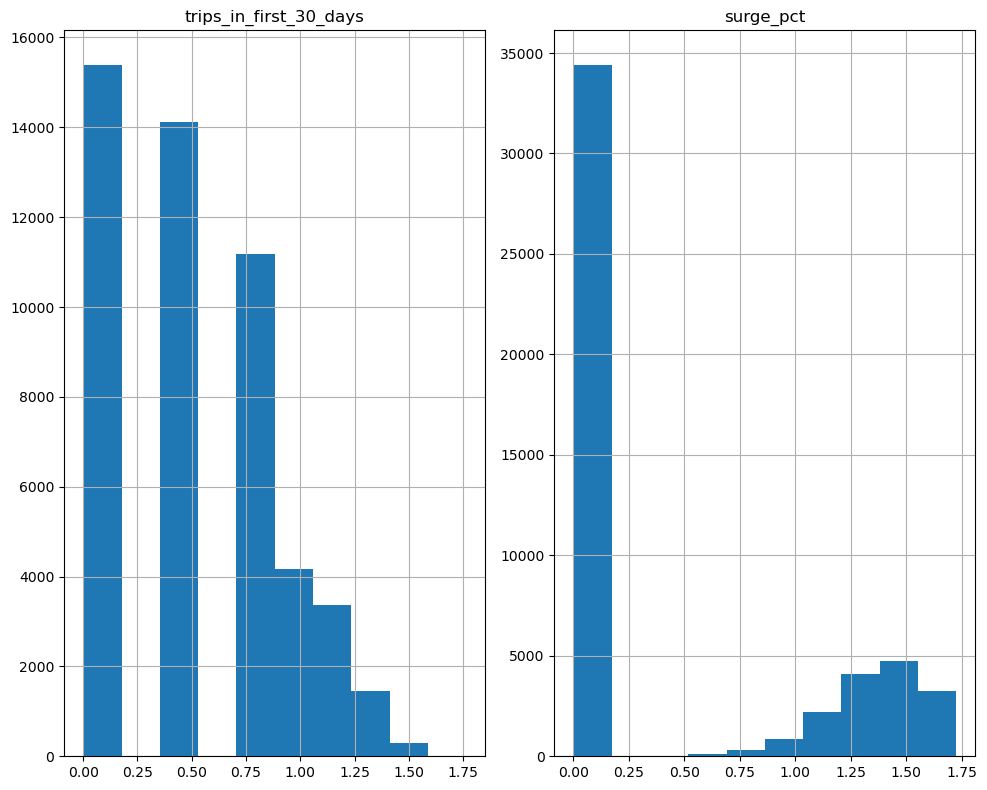

In [24]:
df_model['surge_pct'] = np.log1p(df_model['surge_pct'])
df_model['trips_in_first_30_days'] = np.log1p(df_model['trips_in_first_30_days'])
df_model[['trips_in_first_30_days','surge_pct']].hist(figsize=(10,8))
plt.tight_layout()

In [25]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  float64
 1   signup_date             50000 non-null  int32  
 2   last_trip_date          50000 non-null  int32  
 3   surge_pct               50000 non-null  float64
 4   ultimate_black_user     50000 non-null  int64  
 5   weekday_pct             50000 non-null  float64
 6   active                  50000 non-null  int64  
 7   city_Astapor            50000 non-null  bool   
 8   city_Kings_Landing      50000 non-null  bool   
 9   city_Winterfell         50000 non-null  bool   
 10  phone_Android           50000 non-null  bool   
 11  phone_iPhone            50000 non-null  bool   
dtypes: bool(5), float64(3), int32(2), int64(2)
memory usage: 2.5 MB


In [26]:
df_model.active.value_counts()

active
0    31196
1    18804
Name: count, dtype: int64

In [27]:
# let start training with different modesl

# Logistic Classification 

# start with  preparing data for modelling 
y = df_model['active'].values.tolist()
X = df_model.drop(['active','last_trip_date'],axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)


In [29]:
def Conf_Matrix(CM, labels=['Not Retained', 'Retained']):
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name = 'TRUE'
    df.columns.name = 'PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

In [35]:
def train_and_score_model(model_name,estimator, param_grid=None,cv = 5):
    kfold = model_selection.KFold(n_splits=5)
    
    if model_name == 'Support Vector Machine':
        imputer = SimpleImputer(strategy='mean', fill_value=np.nan)
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

    Cv_rfc = RandomizedSearchCV(estimator, param_grid, cv = kfold, random_state = 1)
    
    t0 = time.time()
    if model_name == 'Support Vector Machine':
       Cv_rfc.fit(X_train_imputed, y_train)
    else:
       Cv_rfc.fit(X_train, y_train)
    parameters = Cv_rfc.best_params_
    training_time = time.time() - t0 #  "time to train"
    print("It takes %.3f seconds for %s fitting" % (training_time, model_name))   
   
    if model_name == 'Support Vector Machine':
        predictions = Cv_rfc.predict(X_test_imputed)
    else :
        predictions = Cv_rfc.predict(X_test)
    
    if model_name != 'Support Vector Machine':
       prediction_prob_test = Cv_rfc.predict_proba(X_test)[:,1]
    
    print('*'*60)
    print({model_name},'Classifer - Test Data: Confusion matrix')
    print(confusion_matrix(y_test,predictions))
    print('****** RandomForest Classifer, with randomized Search Classification report ***Test Data ****')
    print(classification_report(y_test,predictions))    
    print('\n')
    print(f'{model_name} Classifer tree: Accuracy score - Test Data : {accuracy_score(y_test,predictions)}' )
    print('*'*60) 

    if model_name != 'Support Vector Machine':
        fpr,tpr,thresholds = roc_curve(y_test,prediction_prob_test)
        roc_auc = roc_auc_score(y_test, prediction_prob_test)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate (sensitivity)')
        plt.title('Receiver Operating Characteristic (1- specificity)')
        plt.legend(loc='lower right')
    
    return parameters

It takes 24.403 seconds for Random Forest fitting
************************************************************
{'Random Forest'} Classifer - Test Data: Confusion matrix
[[8059 1320]
 [2136 3485]]
****** RandomForest Classifer, with randomized Search Classification report ***Test Data ****
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      9379
           1       0.73      0.62      0.67      5621

    accuracy                           0.77     15000
   macro avg       0.76      0.74      0.75     15000
weighted avg       0.77      0.77      0.77     15000



Random Forest Classifer tree: Accuracy score - Test Data : 0.7696
************************************************************
It takes 8203.048 seconds for Support Vector Machine fitting
************************************************************
{'Support Vector Machine'} Classifer - Test Data: Confusion matrix
[[7944 1435]
 [2183 3438]]
****** RandomForest Classifer, with ra

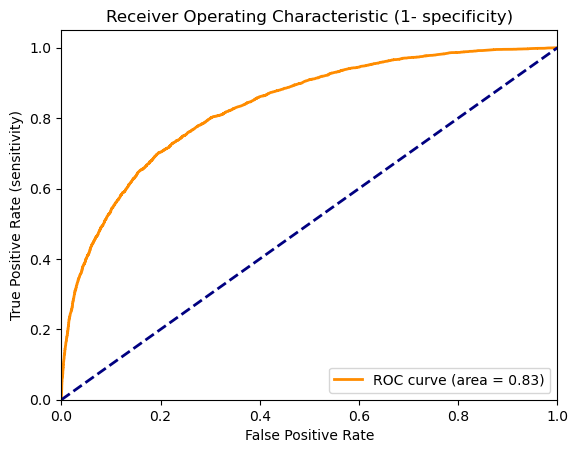

In [36]:
%%time

rclf = RandomForestClassifier (random_state = 0)
rsvm = SVC(random_state=0)

param_grid_rf = {
         'n_estimators': [10, 20, 30],
         'max_depth': [None, 10, 20,25,30],
         'min_samples_split': [2, 5, 10],
         'min_samples_leaf': [1, 2,4],
         'criterion': ['gini', 'entropy'],
    }
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01]
}
RF_parameters = train_and_score_model('Random Forest',rclf, param_grid_rf)
SVM_parameters = train_and_score_model('Support Vector Machine',rsvm, param_grid_svm)

Optimal thresh hold value -- 0.5
-----------------------------------------------------------------------------------------------------



************************************************************
RandomForest Classifer - Test Data: Confusion matrix
[[7961 1418]
 [2035 3586]]
****** RandomForest Classifer, with randomized Search Classification report ***Test Data ****
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      9379
           1       0.72      0.64      0.68      5621

    accuracy                           0.77     15000
   macro avg       0.76      0.74      0.75     15000
weighted avg       0.77      0.77      0.77     15000



RandomForest Classifer tree: Accuracy score - Test Data : 0.7698
************************************************************
CPU times: total: 828 ms
Wall time: 828 ms


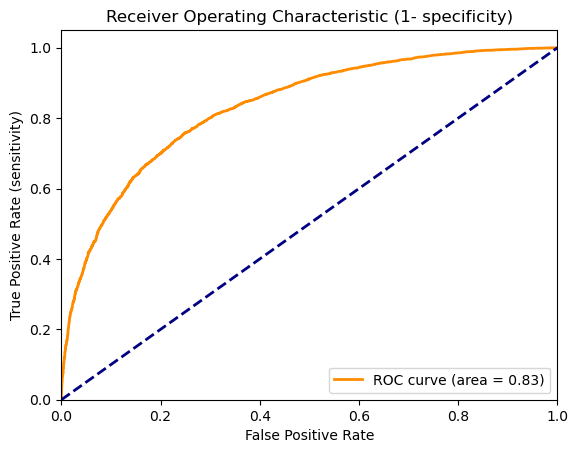

In [37]:
%%time
clf=RandomForestClassifier(n_estimators=RF_parameters['n_estimators'],min_samples_split=RF_parameters['min_samples_split']\
                           ,min_samples_leaf = RF_parameters['min_samples_leaf']\
                           ,max_depth= RF_parameters['max_depth']
                           ,criterion = RF_parameters['criterion'],random_state=42)
clf.fit(X_train,y_train)

thresholds = [0.5,0.55,0.6,0.65,0.7,0.8]
acurracy_scores  = []
for threshold in thresholds:
    prediction_prob_train = clf.predict_proba(X_train)
    binary_predictions_train = (prediction_prob_train[:,1] >= threshold).astype(int)
    acurracy_scores.append(accuracy_score(y_train,binary_predictions_train))
            
optimal_threshold = thresholds[np.argmax(acurracy_scores)]
print(f'Optimal thresh hold value -- {optimal_threshold}')
print('-----------------------------------------------------------------------------------------------------')
print('\n\n')
predictions = clf.predict(X_test)
prediction_prob_test = clf.predict_proba(X_test)[:,1]

print('*'*60)
print('RandomForest Classifer - Test Data: Confusion matrix')
print(confusion_matrix(y_test,predictions))
print('****** RandomForest Classifer, with randomized Search Classification report ***Test Data ****')
print(classification_report(y_test,predictions))    
print('\n')
print(f'RandomForest Classifer tree: Accuracy score - Test Data : {accuracy_score(y_test,predictions)}' )
print('*'*60) 

fpr,tpr,thresholds = roc_curve(y_test,prediction_prob_test)
roc_auc = roc_auc_score(y_test, prediction_prob_test)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (sensitivity)')
plt.title('Receiver Operating Characteristic (1- specificity)')
plt.legend(loc='lower right')
    

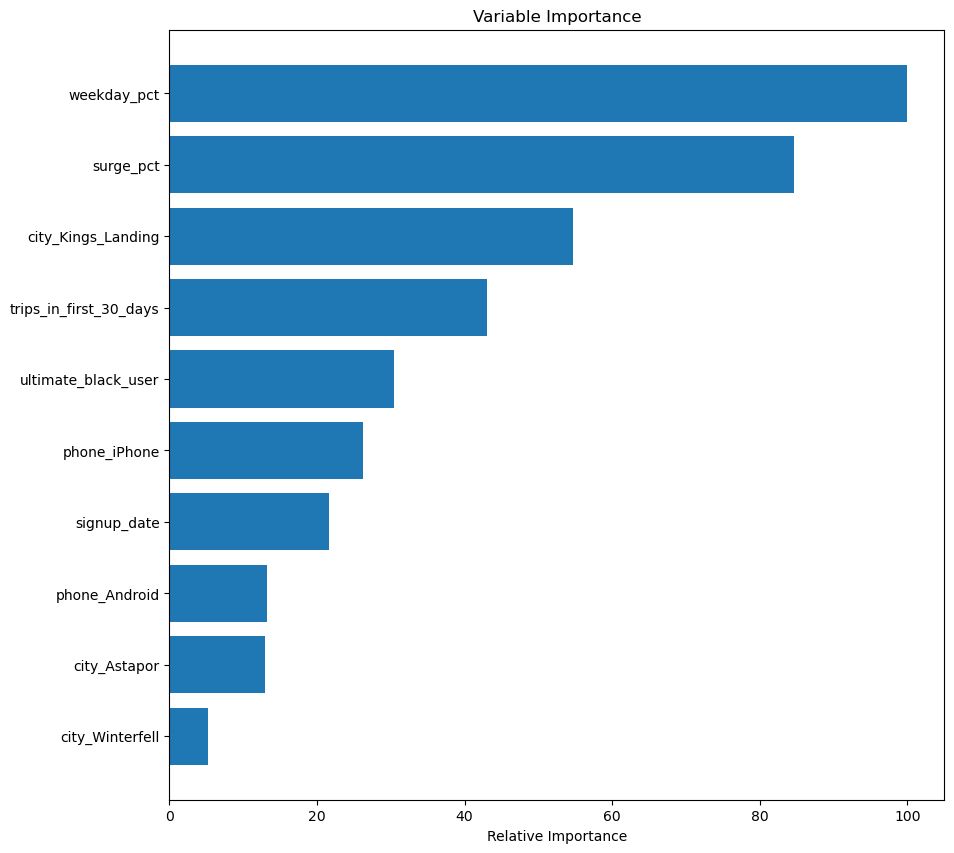

CPU times: total: 188 ms
Wall time: 187 ms


In [38]:
%%time
#clf.fit(X_train, y_train)
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5

sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


We see that Random Forest produces the best model, with an accuracy of about 77%. In addition to having the highest accuracy of any model, we also see that is has the best AUC score of any model, or the best tradeoff between True positive rate and False positive rate. Note that here, 'positive rate' is defined as the rate at which we correctly identify 'retained'. That is, we consider the positive class to be the retained customers, and the negative class to be the customers who were not retained. Also note that we have no AUC score for our SVM model because the SVC class in scikit-learn does not have a predict_proba method.

We don't really need to look at the precision and recall scores because they are captured in the AUC scores for every model. And since Random Forest has the best AUC score and best accuracy, it is our best model.

Note that we are able to achieve better or worse results for accuracy, precision, and recall by varying the probability at which we classify retention. By default, the probability threshold is set at 50%, as this is the intuitive level for classification. But if we cared more about recall, for example, we would lower the threshold for classification to make sure that we classified as retained more of the customers who were actually retained. This would come at the price of precision. Correspondingly, if we cared more about precision, we would raise the probability threshold.

In our scenario, in order to determine which one we care more about maximizing, we have to ask ourselves the folowing question: What do we want to avoid more: predicting that a retained customer will not be retained (false negatives)? Or predicting that a non-retained customer will be retained (false positives)? A good case can be made for each. Since we don't have enough information to make that decision, we will not adjust the threshold.

In terms of any concerns we have, the biggest concern would be that we might value false negative more highly than false positives or vice-versa. In that case, we would want to adjust the probability threshold for classification to reflect that. In any case, Random Forest remains the best model due to it having the best precision-recall curve of any model.

In terms of model validity, our model is only as accurate as the input data. Also, our model is only as good as we the degree to which we know how to use it. That goes back to the point about precion-recall. First we have to know which we care about more before we can use our model optimally.

Finally, to reiterate the indicators of model performance, we achieved an accuracy of about 78%, and an AUC score of about 84.7%.

So we see that the top 3 features in terms of importance are the rider’s average rating over all of their trips, the percent of trips taken with surge multiplier > 1, and the percent of the user's trip occuring during a weekday.